In [1]:
import pandas as pd
import json 
from collections import *
from glob import glob
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from numpy import reshape
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
tqdm.pandas()

In [4]:
PRIDE_PATH = '/shared/2/projects/contextual-appropriateness/data/PRIDE/data/'
pride_df = pd.read_csv(PRIDE_PATH + '/cleaned_pride_data.csv')
pride_df.head()

,quote,relationship,inst_id,length,text,answer
0,"Sir , that is true .",a person to their enemy,0,4,Rate whether it is inappropriate for this mess...,yes
1,"Yes , sir .",a person to their enemy,1,2,Rate whether it is inappropriate for this mess...,yes
2,"Well , I am sure we are all glad to see you ca...",a person to their enemy,2,16,Rate whether it is inappropriate for this mess...,yes
3,And what is the state of your memory now ?,a person to their enemy,4,9,Rate whether it is inappropriate for this mess...,yes
4,"I am sorry , what was the question ?",a person to their enemy,5,7,Rate whether it is inappropriate for this mess...,yes


In [5]:
only_pride_verbalizaion=  {
    'parent': 'a parent to their child',
    'child': 'a child to their parent',
    'sibling': 'a person to their sibling',
    'married': 'a person to their spouse', 
    'friend': 'a person to their friend',
    'enemy': 'a person to their enemy',
    'lover':'a person to their lover',
    'colleague': 'a person to their colleague',
    'doctor': 'a person to a medical professional',
    'commercial':'a person to someone in a commercial relationship',
    'direct_report': 'a person to their boss',
    'boss': 'a boss to their employee',
    "student":'a student to their teacher',
    "teacher": 'a teacher to their student',
    "engaged": 'a person to their fiancee',
    "classmate": 'a person to their classmate',
    "acquaintance": 'a person to someone distant',
    'church':'a person to someone in their church'
}
len(only_pride_verbalizaion)
v2r = {v:r for r,v in only_pride_verbalizaion.items()}

In [8]:
pride_df['description'] = pride_df.relationship

In [9]:
pride_df['relationship'] = pride_df.description.apply(lambda x: v2r[x])
pride_df.head()

,quote,relationship,inst_id,length,text,answer,description
0,"Sir , that is true .",enemy,0,4,Rate whether it is inappropriate for this mess...,yes,a person to their enemy
1,"Yes , sir .",enemy,1,2,Rate whether it is inappropriate for this mess...,yes,a person to their enemy
2,"Well , I am sure we are all glad to see you ca...",enemy,2,16,Rate whether it is inappropriate for this mess...,yes,a person to their enemy
3,And what is the state of your memory now ?,enemy,4,9,Rate whether it is inappropriate for this mess...,yes,a person to their enemy
4,"I am sorry , what was the question ?",enemy,5,7,Rate whether it is inappropriate for this mess...,yes,a person to their enemy


In [10]:
orig_rel = pride_df[['inst_id', 'relationship']].copy()
orig_rel = orig_rel.rename(columns={"inst_id": "pride_id", "relationship": "true_rel_label"})
orig_rel.head()

,pride_id,true_rel_label
0,0,enemy
1,1,enemy
2,2,enemy
3,4,enemy
4,5,enemy


In [6]:
peft_outdir = '/shared/2/projects/contextual-appropriateness/results/peft/'
part1 = pd.read_csv(peft_outdir + 'all_rel_PRIDE.pride-rels.part1.labeled.csv')
part2 = pd.read_csv(peft_outdir + 'all_rel_PRIDE.pride-rels.part2.labeled.csv')

long_df = pd.concat([part1, part2])
long_df.head()

,pride_id,text,relationship,answer,prediction
0,0,Rate whether it is inappropriate for this mess...,boss,yes,yes
1,0,Rate whether it is inappropriate for this mess...,married,yes,yes
2,0,Rate whether it is inappropriate for this mess...,church,yes,yes
3,0,Rate whether it is inappropriate for this mess...,child,yes,yes
4,0,Rate whether it is inappropriate for this mess...,doctor,yes,yes


In [11]:
def to_long(sdf):
    d = {}
    for row in sdf.itertuples():
        d[row.relationship] = 1 if row.prediction == 'yes' else 0

    return pd.Series(d)

df = long_df.groupby('pride_id').progress_apply(to_long).reset_index()
df.head()

  0%|          | 0/47801 [00:00<?, ?it/s]

,pride_id,boss,married,church,child,doctor,colleague,sibling,direct_report,parent,student,classmate,engaged,teacher,commercial,acquaintance,lover,friend,enemy
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
pivoted_df = df.merge(orig_rel, on='pride_id', how='left')
pivoted_df.head()

,pride_id,boss,married,church,child,doctor,colleague,sibling,direct_report,parent,student,classmate,engaged,teacher,commercial,acquaintance,lover,friend,enemy,true_rel_label
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,enemy
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,enemy
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,enemy
3,4,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,enemy
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,enemy


In [90]:
len(df)

47801

In [14]:
rels = set(pivoted_df.true_rel_label)
rels

{'acquaintance',
 'boss',
 'child',
 'church',
 'classmate',
 'colleague',
 'commercial',
 'direct_report',
 'doctor',
 'enemy',
 'engaged',
 'friend',
 'lover',
 'married',
 'parent',
 'sibling',
 'student',
 'teacher'}

In [92]:
df.columns

Index(['quote', 'true_rel_label', 'parent', 'child', 'sibling', 'married',
       'friend', 'enemy', 'lover', 'colleague', 'doctor', 'commercial',
       'direct_report', 'boss', 'student', 'teacher', 'engaged', 'classmate',
       'acquaintance', 'church', 'uid'],
      dtype='object')

In [15]:
cs_df = defaultdict(list)
still_app_df =  defaultdict(list)

no_enemy_cs = 0
all_cs = 0

for i, row in tqdm(pivoted_df.iterrows(), total=len(pivoted_df)):
    observed_rel = row['true_rel_label']
    is_app = row[observed_rel]
    
    num_cs = 0
    num_ne_cs = 0
    for r in rels:
        if r == observed_rel:
            continue
            
        agree = 1 if row[r] == is_app else 0
        cs_df['Actual'].append(observed_rel)                
        cs_df['Imagined'].append(r)
        cs_df['Same_Judgment'].append(agree)        

        if is_app == 1:
            still_app = 1 if row[r] == is_app else 0
            still_app_df['Actual'].append(observed_rel)                
            still_app_df['Imagined'].append(r)
            still_app_df['Same_Judgment'].append(still_app)
            if still_app == 0:
                num_cs += 1
                if r != 'enemy':
                    num_ne_cs += 1
        
    if is_app:
        if num_ne_cs > 0:
            no_enemy_cs += 1
        if num_cs > 0:
            all_cs += 1
            
print(all_cs / len(df), no_enemy_cs / len(df))
           
        
cs_df = pd.DataFrame(cs_df)
still_app_df = pd.DataFrame(still_app_df)
cs_df.head()


  0%|          | 0/47801 [00:00<?, ?it/s]

0.19459843936319324 0.18844794041965648


,Actual,Imagined,Same_Judgment
0,enemy,married,1
1,enemy,church,1
2,enemy,colleague,1
3,enemy,engaged,1
4,enemy,acquaintance,1


In [26]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

<Axes: xlabel='Same_Judgment', ylabel='Actual'>

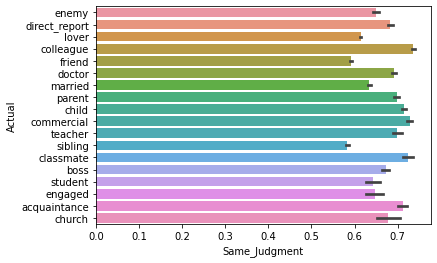

In [27]:
sns.barplot(data=cs_df, x='Same_Judgment', y='Actual')

In [97]:
still_app_df.head()

,Actual,Imagined,Same_Judgment
0,enemy,sibling,0
1,enemy,child,1
2,enemy,teacher,1
3,enemy,boss,1
4,enemy,lover,1


In [98]:
still_app_df.head()

,Actual,Imagined,Same_Judgment
0,enemy,sibling,0
1,enemy,child,1
2,enemy,teacher,1
3,enemy,boss,1
4,enemy,lover,1


In [16]:
clean_names =  {
    'parent': 'from parent to child',
    'child': 'from child to parent',
    'sibling': 'to a sibling',
    'married': 'to a spouse', 
    'friend': 'to a friend',
    'enemy': 'to an enemy',
    'lover':'to a lover',
    'colleague': 'to a colleague',
    'doctor': 'to a medical professional',
    'commercial':'to a commercial associate',
    'direct_report': 'from employee to a boss',
    'boss': 'from boss to an employee',
    "student":'from student to teacher',
    "teacher": 'from teacher to student',
    "engaged": 'to a fiancee',
    "classmate": 'to a classmate',
    "acquaintance": 'to an acquaintance',
    'church':'to someone in their church'
}

still_app_df2 = still_app_df.replace({"Actual": clean_names})
set(still_app_df2.Actual)

{'from boss to an employee',
 'from child to parent',
 'from employee to a boss',
 'from parent to child',
 'from student to teacher',
 'from teacher to student',
 'to a classmate',
 'to a colleague',
 'to a commercial associate',
 'to a fiancee',
 'to a friend',
 'to a lover',
 'to a medical professional',
 'to a sibling',
 'to a spouse',
 'to an acquaintance',
 'to an enemy',
 'to someone in their church'}

In [20]:
still_app_df2.head()

,Actual,Imagined,Same_Judgment
0,to an enemy,married,1
1,to an enemy,church,1
2,to an enemy,colleague,1
3,to an enemy,engaged,1
4,to an enemy,acquaintance,1


In [23]:
mean_app = still_app_df2.groupby(['Actual'])['Same_Judgment'].mean().reset_index().sort_values('Same_Judgment', ascending=False)
mean_app.head()
order = mean_app.Actual

In [24]:
len(still_app_df2)

208454

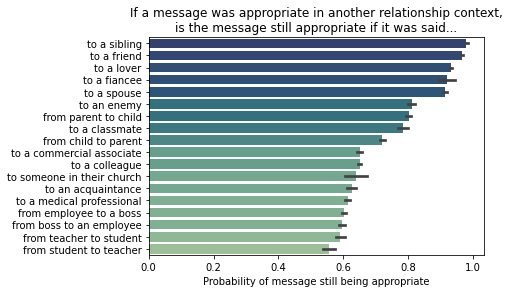

In [28]:
ax = sns.barplot(data=still_app_df2, x='Same_Judgment', y='Actual', order=order,
                palette=colors_from_values(mean_app.Same_Judgment, "crest"))
title = 'If a message was appropriate in another relationship context,\n' \
        + 'is the message still appropriate if it was said...'
ax.set_title(title)
ax.set(xlabel='Probability of message still being appropriate', ylabel='')
plt.savefig('../../plots/pride-context-sensitivity.flan-t5-xl.pdf', bbox_inches = "tight")